In [1]:
#Import Packages
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
import camb 
from camb import model, initialpower
%matplotlib inline


In [2]:
def basicgenmap(_strt, _stop, _NSIDE):  # (start, stop, NSIDE)
    '''
    Generate a basic map which is just an array with element values which are increasing from a 'start' to a 'stop'.
    '''
    _NPIX = 12*_NSIDE**2 #The number of pixels in a map, NPIX = 12*(NSIDE)^2
    return   np.linspace(_strt,_stop,_NPIX)        #generates an array in the 'ring' scheme


In [3]:
#Use CAMB to generate a power spectrum
def call_CAMB_map(_parameters, _lmax): #lmax above 2551 makes no difference?
    '''
    parameters = [H0, ombh2, omch2, mnu, omk, tau]  = [Hubble Const, Baryon density, DM density, 
    Sum 3 neutrino masses/eV, Curvature parameter (Omega kappa), Reionisation optical depth]
    '''
    if _lmax <= 2551: #can only find power spectrum for lmax <= 2551 since that is the maximum value of the data.
        pars = camb.CAMBparams()
        pars.set_cosmology(H0 = _parameters[0], ombh2 = _parameters[1], omch2 = _parameters[2], mnu = _parameters[3],
                   omk = _parameters[4], tau = _parameters[5])  #Inputs the given cosmological parameters.
        pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
        
        pars.set_for_lmax(_lmax, lens_potential_accuracy=0) #input the given lmax value
        
        results = camb.get_results(pars)
        powers =results.get_cmb_power_spectra(pars, CMB_unit='muK') #returns the power spectrum in units muK.
        
        totCL=powers['total'] #returns the total (averaged) power spectrum - including lensed, unlensed power spectra 
        _DL = totCL[:,0] 
        
        #unlensedCL=powers['unlensed_scalar'] #returns the unlensed scalar power spectrum
        #_DL = unlensedCL[:,0] # 
    
        _l = np.arange(len(_DL)) #not sure this CL is actually CL but is actually DL
        _CL = []
        for i in range(_lmax): #also limits the length of power spectrum to the requested length
            if i == 0:
                _CL.append(_DL[i]) #since unsure what CL value is for this DL
        
            else:
                _CL.append(_DL[i]/(_l[i]*(_l[i] + 1)))
        
        _CL = np.array(_CL)    
    
        return _CL 
    
    else: #prints error if lmax is too large.
        print('lmax value is larger than the available data.')

In [4]:
#Plots a given power spectrum 
def plotpwrspctrm(_cls):
    _l = np.arange(len(_cls))
    plt.figure()
    plt.plot(_l, _l * (_l + 1) * _cls)
    plt.xlabel("$\l$")
    plt.ylabel("$\l(\l+1)C_{\l}$")
    plt.grid()
    plt.title("Power Spectrum")
    plt.show()

#PLots a map in the molleview projection 
def aithoffmap(_map):
    hp.mollview(_map, title="Map displayed in the Aithoff projection", cmap = None)
    hp.graticule()


In [5]:
#Adds random noise to each pixel on a map given a variance 
def noisemap(_map,_var):
    _noisevec = np.random.normal(0,_var,len(_map))
    _newmap = [x + y for x, y in zip(_map, _noisevec)]
    _newmap, _noisevec = np.array(_newmap), np.array(_noisevec)
    return [_newmap, _noisevec] #rerturns an array consisiting of [map with added noise, array of the added noise]


In [60]:
#cls --> something
def cltoalm(_cls, _NSIDE): #does this manually - doesn't work
    _alms = []
    _lmax = (3*_NSIDE)
    _count = 0
    for l in range(_lmax): 
        _alms.append(np.complex(np.random.normal(0,_cls[l]),0))        #set m=0, which is real
        for m in range(l): #set positive m's
            _alms.append(np.complex(np.random.normal(0,0.5*_cls[l]),np.random.normal(0,0.5*_cls[m])))
    return _alms   

def hpcltoalm(_cls, _NSIDE): #Healpy generate alms given cls
    return hp.synalm(_cls, lmax = (3*_NSIDE) - 1, new = True)

def cltomap(_cls, _NSIDE):
    _alm = cltoalm(_cls, _NSIDE)
    return almtomap(_alm, _NSIDE)

def hpcltomap(_cls, _NSIDE):   #Healpy generate a map given a power spectrum
    return hp.synfast(_cls, _NSIDE, new=True)   #pixwin=False, fwhm=np.radians(7.0),


In [7]:
#map --> something
def maptocl(_map):
    return

def hpmaptocl(_map): #Generate a power spectrum given cls
    return hp.anafast(_map, lmax=int(((3*(len(_map)/12)**0.5)-1)))    #lmax = 3NSIDE -1 by default

def maptoalm(_map):
    _omegp = (4*np.pi)/len(_map)
    _lmax = int(np.sqrt(len(_map)*(3/4)))
    _NSIDE = int(_lmax/3)
    _alm = []
    for l in range(_lmax):
        for m in range(l+1):
            _TpYlm = []
            for i in range(len(_map)):
                _TpYlm.append(_map[i]*np.conjugate(sphharm(m, l, i, _NSIDE)))
                    
            _alm.append(_omegp*sum(_TpYlm))
    
    return _alm


def hpmaptoalm(_map, _lmax): #Healpy generate alms from map. 
    return hp.map2alm(_map, _lmax)


In [85]:
#alm --> something
def almtocl(_alm,lmax): #not the same value as healpy
    _l = np.arange(lmax)
    _scaling = 1 / ((2*_l + 1))
    count = 0
    _new = []
    _cl = []
    for l in range(lmax):
        _new.append([])
        for m in range(l):
            if m == 0:
                _new[l].append(np.absolute(_alm[count])**2)
                count = count + 1
                
            if m > 0:
                _new[l].append(2*np.absolute(_alm[count])**2)
                count = count + 1
              
    for i in range(len(_new)):
        _cl.append(_scaling[i] * sum(_new[i]))
    
    return _cl

def hpalmtocl(_alms, _lmax): #Healpy estimates the power spectrum from the cls.
    return hp.alm2cl(_alms, lmax = _lmax)

def almtomap(_alm, _NSIDE):
    _map = []
    _lmax = (3*_NSIDE)
    for i in range(12*(_NSIDE)**2):
        _sum = []
        _count = 0
        for l in range(_lmax+1):
            for m in range(l):
                _sum.append(_alm[_count]*sphharm(m,l,i, _NSIDE))
                _count = _count + 1
        _map.append(abs(sum(_sum)))
    return _map


def hpalmtomap(_alms, _NSIDE):
    return hp.alm2map(_alms, _NSIDE)

In [9]:
def hpmapsmooth(_map, _lmax): #smooths a given map with a gaussian beam smoother.
    return hp.smoothing(_map, lmax = _lmax)

def hpalmsmooth(_alms): #smooths a given set of alms with a gaussian beam smoother.
    return hp.smoothalm(_alms, fwhm = 0.0)
    

In [10]:
def singulartosplitalm(_alm):
    _realalm, _imagalm = _alm.real, _alm.imag
    return [_realalm, _imagalm]
    

def splittosingularalm(_realalm, _imagalm):
    _alm = []
    for i in range(len(_realalm)):
        _alm.append(complex(_realalm[i], _imagalm[i]))
    return _alm

In [11]:
def sphharm(m, l, _pixno, _NSIDE):
    _theta, _phi = hp.pix2ang(nside=_NSIDE, ipix=_pixno)
    return sp.special.sph_harm(m, l, _theta, _phi)
    

In [93]:
#negative log of the posterior, psi, ignoring the prior term.
def psi(_params, _lmax, _Ninv): #unnormalised log probability
    _cl, _realalm, _imagalm = [], [], []
    
    for i in range(a1):
        _cl.append(_params[i])
    for i in range(a2):
        _realalm.append(_params[i + a1])
    for i in range(a2):
        _imagalm.append(_params[i + a1 + a2])
    
    _d = cltomap(_cl, int(_lmax/3))
    _a = splittosingularalm(_realalm, _imagalm)
    _Ya = almtomap(_a, int(_lmax/3))
    _BYa =  _Ya #mapsmooth(_Ya, _lmax)
    
    _elem, _psi = [], []
    for i in range(len(_d)):
        _elem.append(_d[i] - _BYa[i])
        _psi.append(0.5*(_elem[i]**2)*_Ninv[i])
    
    return sum(_psi)


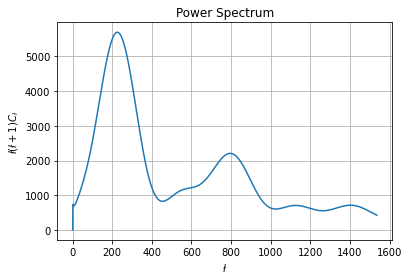

/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colorm

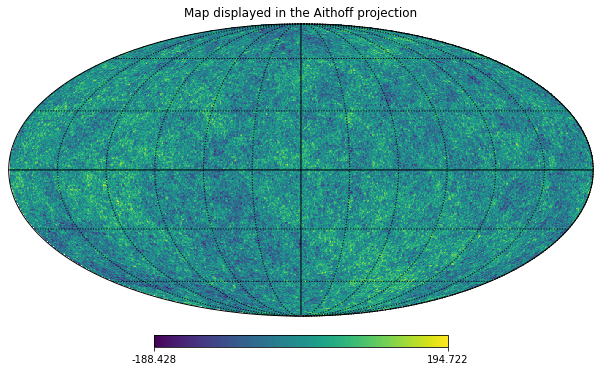

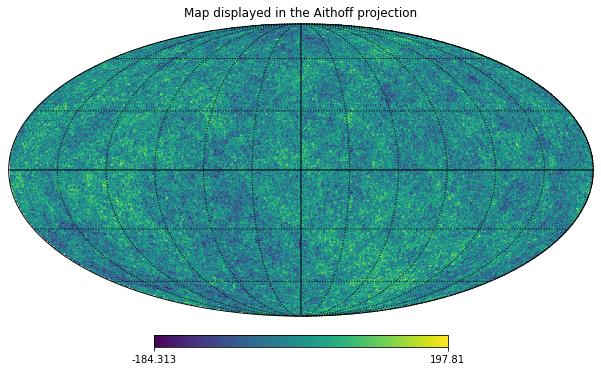

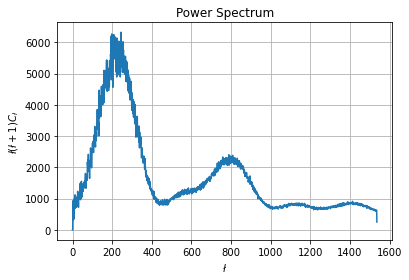

In [11]:
parameters1 = [67.74, 0.0486, 0.2589, 0.06, 0.0, 0.066] #cosmological parameters.
lmax1 = 1536  #lmax value wanted from data
NSIDE1 = int(lmax1/3)  #len(cls1)/3   #3*nside = len(cls)
n1 = np.linspace(5,5,(12*(NSIDE1)**2))
Ninv1 = []
for i in range(len(n1)):
    Ninv1.append(1/(n1[i]**2)) #finds the inverse noise matrix

cls1 = call_CAMB_map(parameters1, lmax1) #power spectrum for the given parameters and lmax.
plotpwrspctrm(cls1) #plot of the power spectrum.
map1 = hpcltomap(cls1, NSIDE1)  #generates a map from the power spectrum
map1 = hpmapsmooth(map1, lmax1) #applies a gaussian beam smoother to the map
aithoffmap(map1) #plots the map
noisemap1 = noisemap(map1,n1[0]) #adds noise to the map
aithoffmap(noisemap1[0]) #plots the map with noise
alms1 = hpmaptoalm(noisemap1[0],lmax1) #computes the alms from the map with noise added.
CLestimate1 = hpalmtocl(alms1, lmax1) #estimates the power spectrum from the given alms.
plotpwrspctrm(CLestimate1) #plots the estimated power spectrum.


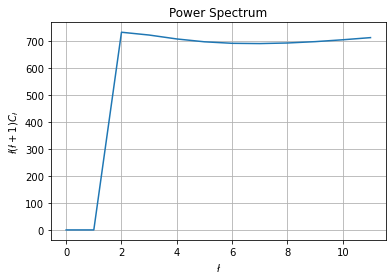

/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colorm

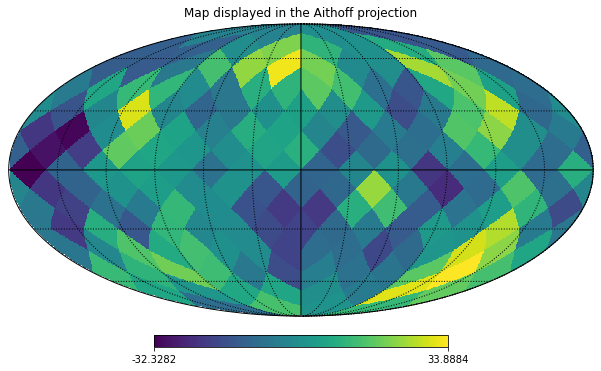

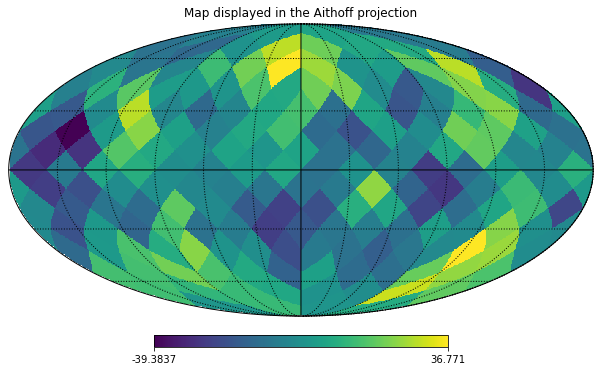

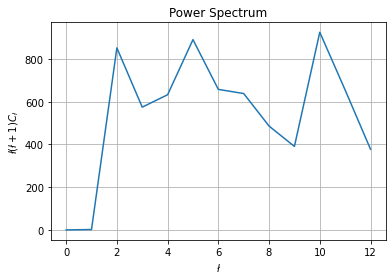

In [12]:
parameters2 = [67.74, 0.0486, 0.2589, 0.06, 0.0, 0.066] #cosmological parameters.
lmax2 = 12   #lmax value wanted from data
NSIDE2 = int(lmax2/3)   #len(cls1)/3   #3*nside = len(cls)
n2 = np.linspace(5,5,(12*(NSIDE2)**2))
Ninv2 = []
for i in range(len(n2)):
    Ninv2.append(1/(n2[i]**2)) #finds the inverse noise matrix
    

cls2 = call_CAMB_map(parameters2, lmax2) #power spectrum for the given parameters and lmax.
plotpwrspctrm(cls2) #plot of the power spectrum.
map2 = hpcltomap(cls2, NSIDE2)  #generates a map from the power spectrum
map2 = hpmapsmooth(map2, lmax2) #applies a gaussian beam smoother to the map
aithoffmap(map2) #plots the map
noisemap2 = noisemap(map2,n2[0]) #adds noise to the map
aithoffmap(noisemap2[0]) #plots the map with noise
alms2 = hpmaptoalm(noisemap2[0],lmax2) #computes the alms from the map with noise added.
CLestimate2 = hpalmtocl(alms2, lmax2) #estimates the power spectrum from the given alms.
plotpwrspctrm(CLestimate2) #plots the estimated power spectrum.


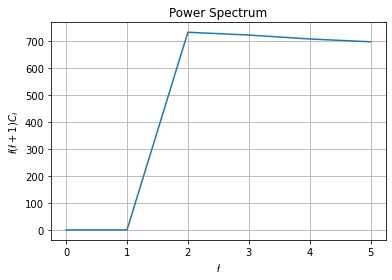

/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colorm

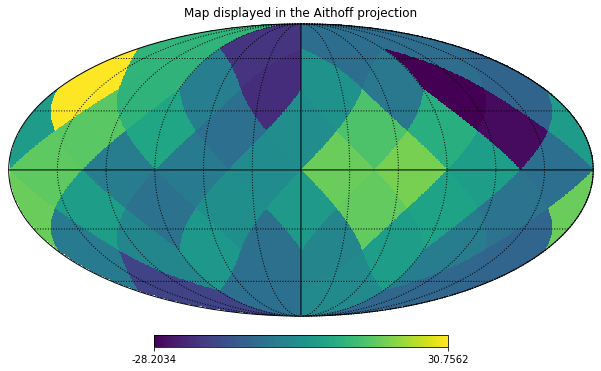

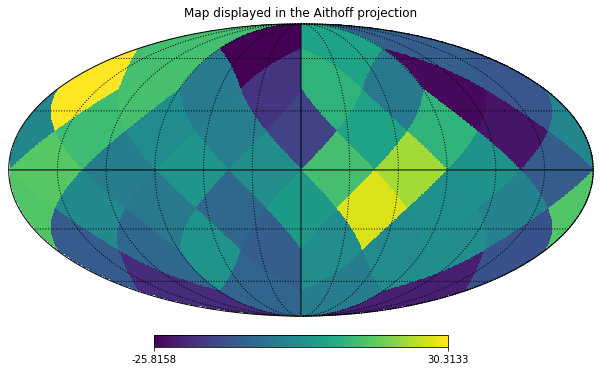

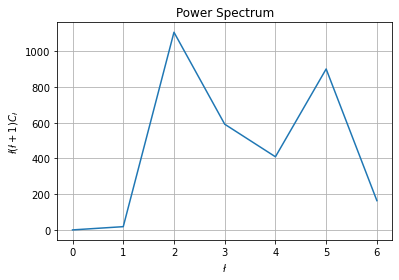

In [13]:
parameters3 = [67.74, 0.0486, 0.2589, 0.06, 0.0, 0.066] #cosmological parameters.
lmax3 = 6  #lmax value wanted from data
NSIDE3 = int(lmax3/3)  #len(cls1)/3   #3*nside = len(cls)
n3 = np.linspace(5,5,(12*(NSIDE3)**2))
Ninv3 = []
for i in range(len(n3)):
    Ninv3.append(1/(n3[i]**2)) #finds the inverse noise matrix

cls3 = call_CAMB_map(parameters3, lmax3) #power spectrum for the given parameters and lmax.
plotpwrspctrm(cls3) #plot of the power spectrum.
map3 = hpcltomap(cls3, NSIDE3)  #generates a map from the power spectrum
map3 = hpmapsmooth(map3, lmax3) #applies a gaussian beam smoother to the map
aithoffmap(map3) #plots the map
noisemap3 = noisemap(map3,n3[0]) #adds noise to the map
aithoffmap(noisemap3[0]) #plots the map with noise
alms3 = hpmaptoalm(noisemap3[0],lmax3) #computes the alms from the map with noise added.
CLestimate3 = hpalmtocl(alms3, lmax3) #estimates the power spectrum from the given alms.
plotpwrspctrm(CLestimate3) #plots the estimated power spectrum.


In [66]:
parameters4 = [67.74, 0.0486, 0.2589, 0.06, 0.0, 0.066] #cosmological parameters.
lmax4 = 6  #lmax value wanted from data
NSIDE4 = int(lmax4/3)  #len(cls1)/3   #3*nside = len(cls)
n4 = np.linspace(5,5,(12*(NSIDE4)**2))
Ninv4 = []
for i in range(len(n4)):
    Ninv4.append(1/(n4[i]**2)) #finds the inverse noise matrix
    
cls4 = call_CAMB_map(parameters4, lmax4) #power spectrum for the given parameters and lmax.

In [69]:
bee = almtomap(noisealm4, NSIDE4)
len(bee)

48

In [ ]:
#boris' steps


map4 = hpcltomap(cls4, NSIDE4)  #generates a map from the power spectrum
map4 = hpmapsmooth(map4, lmax4) #applies a gaussian beam smoother to the map
noisemap4 = noisemap(map4,n4[0]) #adds noise to the map

noisealm4 = np.array(maptoalm(noisemap4[0])) #recover cls from map
noisecl4 = almtocl(noisealm4, lmax4)
plotpwrspctrm(noisecl4) #plots the estimated power spectrum.


In [47]:
#minimise psi

noisemap = noisemap4[0]
clinit = noisecl4
realalminit = noisealm4.real
imagalminit = noisealm4.imag
x0 = []
a1 = len(clinit)
a2 = len(realalminit)
a3 = len(imagalminit)
for i in range(len(clinit)):
    x0.append(clinit[i])
for i in range(len(realalminit)):
    x0.append(realalminit[i])
for i in range(len(imagalminit)):
    x0.append(imagalminit[i])

In [95]:
psi(x0,lmax4,Ninv4)

116.09432237497373

In [ ]:
sp.optimize.minimize(psi, x0, args = (lmax4, Ninv4), method = 'Nelder-Mead')

In [111]:
x1 = [ 1.28742211e-04,  1.35131584e+01,  5.27749783e+00,  2.06084829e+01,
        3.06421071e+01,  1.60788608e+01, -6.36162915e+00, -1.87834358e+00,
       -7.33364698e-01, -2.53700820e+00, -5.29597395e+00,  5.83450930e-01,
        1.27023023e+01, -1.23604276e-01, -1.06366301e+00,  4.06984083e+00,
       -3.60332056e+00, -1.44810400e+00, -2.34650364e+00,  3.56829840e+00,
        1.16207944e+00,  1.72125300e+01, -1.30377226e+00,  4.38375403e-01,
        4.43051972e+00,  6.46777878e+00, -4.77871621e+00, -1.11867490e-06,
        2.30159805e-06, -3.29978314e+00,  3.63102096e-06, -5.80637083e+00,
       -2.32326830e+00,  2.37556963e-06,  7.70086991e-01, -6.16249655e+00,
       -1.03242628e+00,  3.68757693e-07, -1.26030495e+00, -1.64793922e+00,
       -5.62594444e+00,  4.93420384e+00, -1.37899892e-06,  9.85061811e-01,
       -2.63560431e+00, -2.99820233e+00,  8.02403455e-01,  7.79683683e-01]

psi(x1, lmax4, Ninv4)


52.948505256416865

In [ ]:
psi1 = psi(noisemap1, lmax1, Ninv1)
psi2 = psi(noisemap2, lmax2, Ninv2)
print('psi1 =', psi1)
print('psi2 =', psi2)

In [ ]:
def nufin(_map): #return the spherical harmonics for each point on the map
    _lmax = int(np.sqrt(len(_map)*(3/4)))
    _NSIDE = int(_lmax/3)
    theta, phi = hp.pix2ang(nside=_NSIDE, ipix=list(np.arange(len(_map))))
    _count = 0
    for l in range(_lmax):
        if l == 0:
            ans = []
        if l >=1:
            ans.append([])
            for m in range(l):
                ans[l-1].append(sp.special.sph_harm(m, l, theta[_count], phi[_count]))
                _count = _count + 1
        
        print(_count)
    return ans



In [49]:
#Initialise HMC kernal
#tf.enable_eager_execution()

num_results = int(10e3)
num_burnin_steps = int(1e3)

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=psi, 
                        num_leapfrog_steps=3, step_size=1.), num_adaptation_steps=int(num_burnin_steps * 0.8))


#@tf.function

def run_chain():
  # Run the chain (with burn-in).
  samples, is_accepted = tfp.mcmc.sample_chain(num_results=num_results, num_burnin_steps=num_burnin_steps,
                        current_state=1., kernel=adaptive_hmc, trace_fn=lambda _,
                                               pkr: pkr.inner_results.is_accepted)

  sample_mean = tf.reduce_mean(samples)
  sample_stddev = tf.math.reduce_std(samples)
  is_accepted = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32))
  return sample_mean, sample_stddev, is_accepted

sample_mean, sample_stddev, is_accepted = run_chain()

print('mean:{:.4f}  stddev:{:.4f}  acceptance:{:.4f}'.format(sample_mean.numpy(), sample_stddev.numpy(),
                                                             is_accepted.numpy()))

InvalidArgumentError: Index out of range using input dim 0; input has only 0 dims [Op:StridedSlice] name: mcmc_sample_chain/simple_step_size_adaptation___init__/_bootstrap_results/mh_bootstrap_results/hmc_kernel_bootstrap_results/maybe_call_fn_and_grads/value_and_gradients/strided_slice/

In [50]:
import tensorflow as tf
import tensorflow_probability as tfp

#tf.enable_eager_execution()

# Target distribution is proportional to: `exp(-x (1 + x))`.
def unnormalized_log_prob(x):
  return -x - x**2.

# Initialize the HMC transition kernel.
num_results = int(10e3)
num_burnin_steps = int(1e3)
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_log_prob,
        num_leapfrog_steps=3,
        step_size=1.),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

# Run the chain (with burn-in).
@tf.function
def run_chain():
  # Run the chain (with burn-in).
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=1.,
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)

  sample_mean = tf.reduce_mean(samples)
  sample_stddev = tf.math.reduce_std(samples)
  is_accepted = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32))
  return sample_mean, sample_stddev, is_accepted

sample_mean, sample_stddev, is_accepted = run_chain()

print('mean:{:.4f}  stddev:{:.4f}  acceptance:{:.4f}'.format(
    sample_mean.numpy(), sample_stddev.numpy(), is_accepted.numpy()))

mean:-0.4911  stddev:0.7187  acceptance:0.5050
